In [1]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import numpy as np

In [2]:
def get_data():
    x_train_ = pd.read_csv('X_train.csv').drop('id', axis=1)
    y_train_ = pd.read_csv('y_train.csv', usecols=['y'])
    x_test_ = pd.read_csv('X_test.csv').drop('id', axis=1)
    return x_train_, y_train_, x_test_

In [3]:
x_train, y_train, x_test = get_data()

## Missing Values
-for each feature we have less then 10% missing values

In [4]:
# replace missing values with the median
x_train = x_train.fillna(x_train.median())
x_test = x_test.fillna(x_test.median())

## visualize features

In [5]:
x_train.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
count,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,...,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000
mean,15207.493620,10942.490030,3428.710255,100006.149219,105.067890,99.949416,9983.691831,10496.424105,10495.725293,9.984612,...,10068.861503,13266.876406,810.727245,104.968727,105.070415,2480.718997,2.724440,1360.161089,1052.356879,9981.095057
std,2226.529196,1515.421465,427.083867,9336.194716,2.746628,9.249012,941.084962,267.219480,278.730159,0.958978,...,928.146417,2084.206603,173.409641,2.692260,2.688126,500.964818,0.253124,255.067715,28.194710,973.447238
min,5636.623777,6764.060541,1849.453269,65828.916291,100.056578,70.232469,6797.836298,10000.771287,10000.339782,6.759685,...,7109.997185,4100.700865,164.997735,100.040624,100.015930,750.038434,1.590647,663.173673,1000.067137,6383.771227
25%,13931.809724,9926.530547,3170.385944,94358.738184,102.811093,94.195727,9428.209799,10284.999365,10263.060018,9.375400,...,9479.523877,12076.791406,702.078405,102.864339,102.902380,2181.823042,2.557012,1194.652957,1030.447895,9382.893669
50%,15048.467618,10839.483074,3401.539562,100053.800306,105.029940,99.670635,9991.006638,10498.862876,10494.225267,9.970521,...,10064.750764,13160.555394,792.045039,104.969600,105.136788,2459.092168,2.710103,1362.350726,1053.778881,9981.210986
75%,16485.603116,11751.038613,3668.158481,105531.874497,107.353976,105.397439,10491.489465,10700.871543,10718.409364,10.606376,...,10648.249140,14431.290607,911.343060,106.993646,107.185396,2743.530473,2.868703,1517.190330,1076.100611,10584.942325
max,28273.690135,17777.338221,5622.951648,133145.632257,110.087261,130.142499,13865.848591,11000.062311,10999.403374,13.828922,...,13173.145338,24901.251674,1589.225040,110.072565,110.069056,4904.988601,3.795277,2506.104650,1099.975679,13265.026039


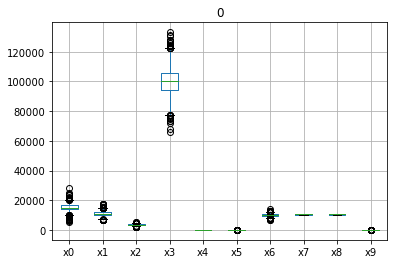

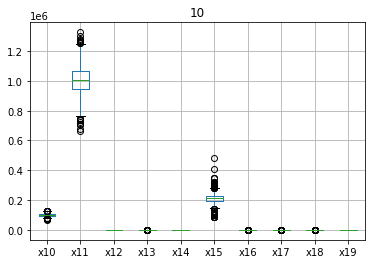

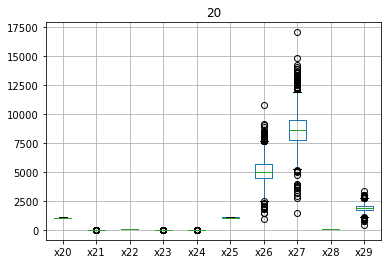

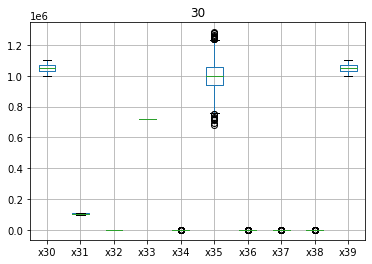

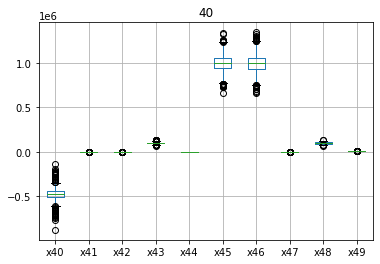

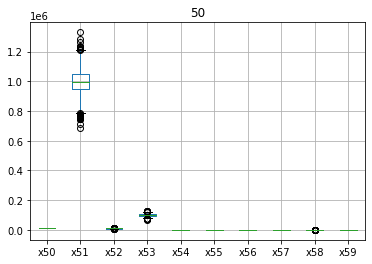

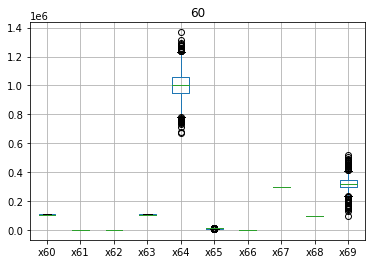

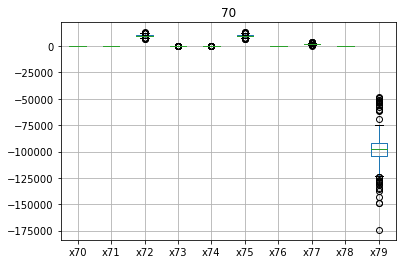

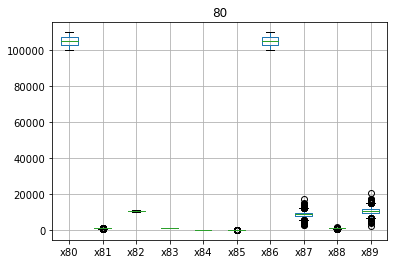

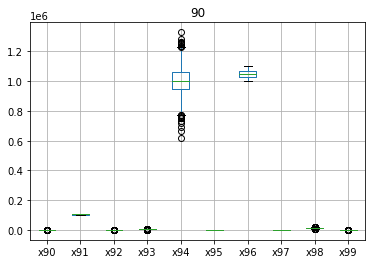

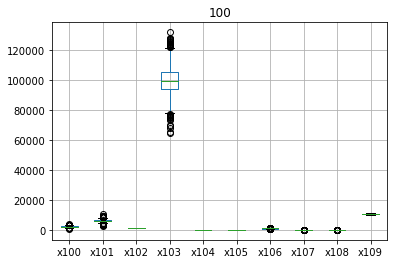

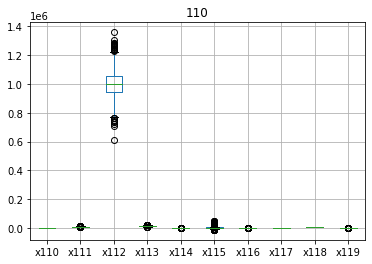

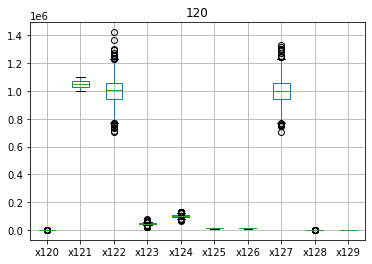

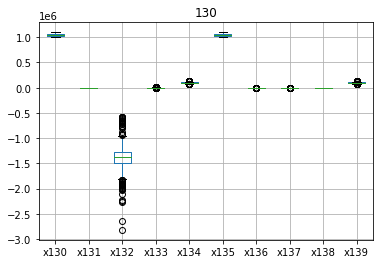

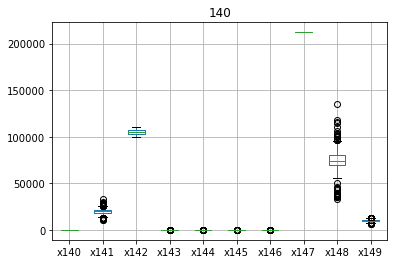

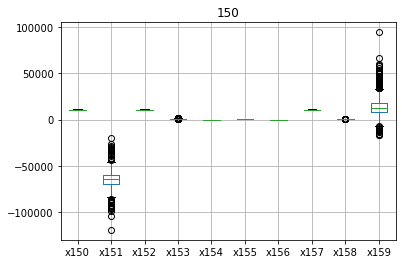

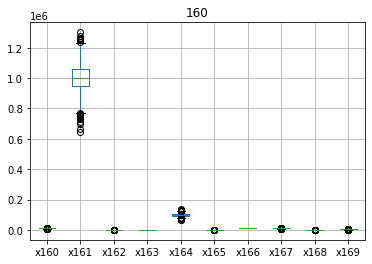

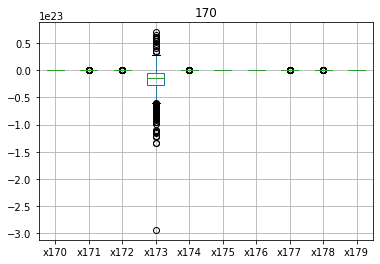

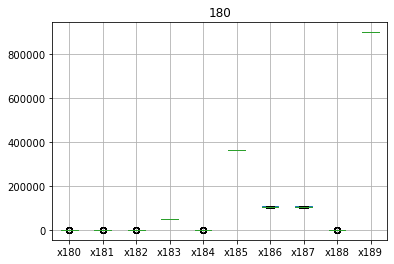

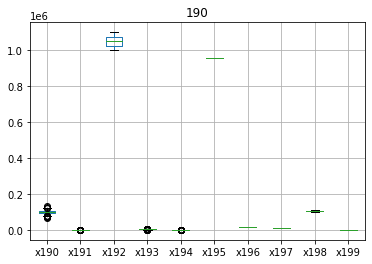

In [6]:
#boxplot of featues
for i in range(20):
    plt.figure()
    plt.title(i*10)
    x_train.iloc[:, i*10:(i+1)*10].boxplot()

In [ ]:
#histogram plot of features
for i in range(20):
    plt.figure()
    plt.title(i)
    x_train.iloc[:,i].hist(bins = 20)

In [ ]:
# age distribution of the training set 
# --> should we do something to balance this?
y_train.hist(bins=50)

## find all features with uniform looking histograms

when looking at the histograms one can notice that some features have uniform looking distributions. From a statistical perspective such features have no information value for predictions. Therfore it might my usefull to remove those features.

In [8]:
X = x_train.to_numpy()[:,:]
test = np.zeros(X.shape[1])

#does the xhi_squared test for each feature and stores a 1 in test if p_value > 0.05
for i in range(X.shape[1]):
    a = np.histogram(X[:,i], bins = 20)[0]
    a = np.delete(a,a.argmax())
    b = np.ones_like(a)*a.sum()/a.shape
    if (chisquare(a,b).pvalue > 0.05):
        test[i] = 1

/Users/paul/miniforge3/envs/tensorflow/lib/python3.9/site-packages/scipy/stats/_stats_py.py:6766: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


In [11]:
test.sum()

217.0

we found 217 features with uniform looking histograms. I ovserved this by measuring the p_value of the chi_squared test on the features. Note that I excluded the maximum value in each histogram as this value appears way more the all the other values (TODO: think about the consequenses of this later on!)
The indices which satisfy:
```python
test[i] == 1
```
are also the indices of the features which have histogram looking distributions.

## Standardization

In [ ]:
# standardization of the data
std_scaler = StandardScaler()
# fit and transform the data
x_train = pd.DataFrame(std_scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(std_scaler.fit_transform(x_test), columns=x_test.columns)